# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import torch
import torchvision.datasets as datasets
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# Define las transformaciones (puedes ajustarlas según tus necesidades)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalización típica de ImageNet
])

train_dataset = datasets.Imagenette(
    root='./data', 
    split='train', 
    size='160px',
    download=False, 
    transform=transform
)

val_dataset = datasets.Imagenette(
    root='./data', 
    split='val', 
    size='160px',
    download=False, 
    transform=transform
)

In [19]:
media = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1) # Shape [3, 1, 1]
std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)   # Shape [3, 1, 1]

Image 0 - Label: 0 - Image shape: torch.Size([3, 160, 213])
Image 1 - Label: 0 - Image shape: torch.Size([3, 160, 213])
Image 2 - Label: 0 - Image shape: torch.Size([3, 160, 213])
Image 3 - Label: 0 - Image shape: torch.Size([3, 160, 213])


C:\Users\Octav\AppData\Local\Temp\ipykernel_1252\1312993416.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image_tensor = (image * std) + media # Desnormaliza la imagen


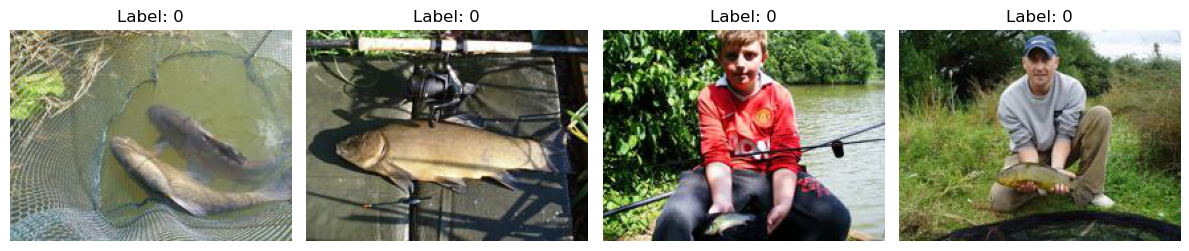

In [20]:
_, ejes = plt.subplots(1, 4, figsize=(12, 4)) 

for i in range(4):
    image, label = train_dataset[i]
    print(f"Image {i} - Label: {label} - Image shape: {image.shape}")
    image_tensor = (image * std) + media # Desnormaliza la imagen
    image_tensor = torch.clamp(image_tensor, 0, 1) # Asegura que los valores estén en el rango [0, 1]
    visible_image = image_tensor.permute(1, 2, 0).numpy()
    plt.imshow(visible_image)

    ax = ejes[i]
    ax.imshow(visible_image)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
    
plt.tight_layout() # Ajusta el espaciado
plt.show() 